In [1]:
import numpy as np
import pandas as pd
import talib
import yfinance as yf
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt


In [2]:
# 下载数据
stock_code = "AAPL"
end_date = pd.Timestamp.now()
start_date = end_date - pd.DateOffset(years=10)
data = yf.download(stock_code, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))

# 特征工程
data['Returns'] = data['Close'].pct_change()
data['HL_PCT'] = (data['High'] - data['Low']) / data['Close'] * 100.0
data['PCT_change'] = (data['Close'] - data['Open']) / data['Open'] * 100.0

# 添加技术指标
data['RSI'] = talib.RSI(data['Close'], timeperiod=14)
data['ADX'] = talib.ADX(data['High'], data['Low'], data['Close'], timeperiod=14)
data['OBV'] = talib.OBV(data['Close'], data['Volume'])
data['MACD'], data['MACD_signal'], data['MACD_hist'] = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
data['ATR'] = talib.ATR(data['High'], data['Low'], data['Close'], timeperiod=14)
data['slowk'], data['slowd'] = talib.STOCH(data['High'], data['Low'], data['Close'], fastk_period=14, slowk_period=3, slowd_period=3)
data['CCI'] = talib.CCI(data['High'], data['Low'], data['Close'], timeperiod=14)
upperband, middleband, lowerband = talib.BBANDS(data['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
data['upperband'] = upperband
data['middleband'] = middleband
data['lowerband'] = lowerband
data['MOM'] = talib.MOM(data['Close'], timeperiod=10)

# 预测标签
prediction_days = 7
data['Future_Close'] = data['Close'].shift(-prediction_days)
data['Target'] = (data['Future_Close'] > data['Close']).astype(int)
data = data.dropna()

# 准备数据集
feature_columns = [col for col in data.columns if col not in ['Close', 'Future_Close', 'Target']]
X = data[feature_columns]
y = data['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 数据归一化
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# 训练随机森林模型，使用最佳参数
best_params = {
    'bootstrap': False,
    'max_depth': None,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 200
}
model = RandomForestClassifier(random_state=42, **best_params)
model.fit(X_train, y_train)


RandomForestClassifier(bootstrap=False, n_estimators=200, random_state=42)

In [ ]:
# 进行预测并评估模型
predictions = model.predict(X_test)
prediction_proba = model.predict_proba(X_test)[:, 1]
report = classification_report(y_test, predictions)
fpr, tpr, _ = roc_curve(y_test, prediction_proba)
roc_auc = roc_auc_score(y_test, prediction_proba)

# 打印评估指标
print("Classification Report:")
print(report)
print("ROC AUC Score:", roc_auc)


Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.72      0.74       198
           1       0.82      0.85      0.84       298

    accuracy                           0.80       496
   macro avg       0.79      0.78      0.79       496
weighted avg       0.80      0.80      0.80       496

ROC AUC Score: 0.8702969290217611


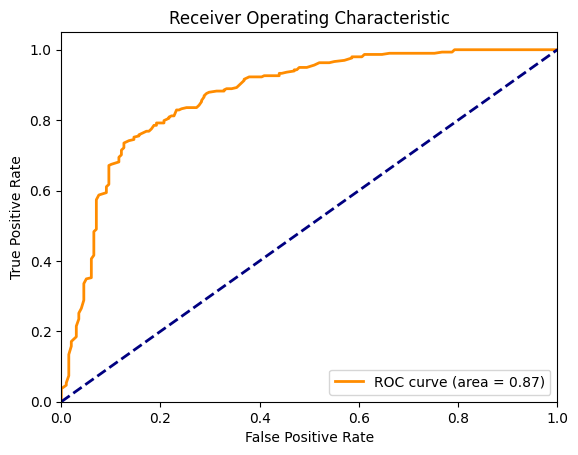

In [ ]:
# 绘制ROC曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (Random_Forest_OP AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()